In [1]:
from __future__ import division
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import healpy as hp
import astropy.units as u
import astropy.constants as c
import scipy.signal as sig
import scipy.special as spec
from numpy import random

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
matplotlib.rcParams.update({'font.size':15})
matplotlib.rcParams['figure.dpi'] = 150
matplotlib.rcParams['figure.figsize'] = [5,3]
matplotlib.rcParams['text.usetex'] = True

# simulated measured HD correlations

In [3]:
def HellingsDowns(gamma, norm=0.5):
    '''
    calculate normalized HD coefficient for angular separation theta in radians
    norm  -  normalization of mu(0) for distinct pulsars (default = 0.5)
    '''
    
    # calculate HD coefficient
    x = (1-np.cos(gamma))/2.
    mu = norm * (3*x*np.log(x) - (1/2)*x + 1)
    var = 0.5 * (4*norm**2 + mu**2) # total variance for confusion noise limit
    
    return mu, var

In [4]:
def simulatePulsars(M, seed):

    '''
    simulate an array of M pulsars placed randomly on the sky with timing noise 
    uniformly distributed between 50 and 150 ns
    
    outputs: theta, phi (radians)
    '''

    # put pulsars at random locations on the sky uniformly distributed in cos(theta) and phi
    np.random.seed(seed)
    cosTheta = -1. + 2.0*np.random.rand(M)
    theta = np.arccos(cosTheta)
    phi = 2.0*np.pi*np.random.rand(M)
    
    return theta, phi

In [5]:
def pulsarPairs(M, seed, norm=0.5, displayFig=False):
    
    '''
    generate a set of M pulsars located randomly on the sky, returning 
    the hellings-downs factor as a M*M matrix.  there are Np=M(M-1)/2 distint
    pulsar pairs
    
    M        - number of pulsars
    seed     - seed for random number generation
    norm     - normalization of HD curve at 0 (default=1/2)

    HDmat    - MxM matrix of hellings-downs factors
    IJ       - mapping from 0,1, ... Np-1 into IJ element of MxM matrix
    thetaIJ  - angles (radians) between pairs of pulsars indexed from 0,1, ... Np-1
    theta, phi - angles (radians) for M simulated pulsars
    '''

    # check that value of M=2 or more
    if M<2:
        print('need at least 2 pulsars')

    # number of distinct pulsar pairs
    Np = int(M*(M-1)/2)

    # simulate M random pulsar locations on the sky
    theta, phi = simulatePulsars(M, seed)

    # define cosTheta, sinTheta
    cosTheta = np.cos(theta)
    sinTheta = np.sin(theta)

    # calculate hellings-downs factor for these angles
    cosThetaIJ = np.zeros((M,M))
    HDmat = np.zeros((M,M))
    for ii in range(M):
        for jj in range(M):
            cosThetaIJ[ii,jj] = cosTheta[ii]*cosTheta[jj] + sinTheta[ii]*sinTheta[jj]*np.cos(phi[ii]-phi[jj])
            x = (1.-cosThetaIJ[ii,jj])/2.

            if jj==ii:
                HDmat[ii,jj] = 2*norm
            else:
                HDmat[ii,jj] = 2*norm*(1.5*x*np.log(x) - 0.25*x + 0.5)

    # construct array of angles
    thetaIJ = np.zeros(Np)
    alphaHD = np.zeros(Np)
    IJ = np.zeros((Np,2), dtype=int)

    ind = 0
    for ii in range(M-1):
        for jj in np.arange(ii+1,M):
            IJ[ind,0] = ii
            IJ[ind,1] = jj
            thetaIJ[ind] = np.arccos(cosThetaIJ[ii,jj])
            alphaHD[ind] =  HDmat[ii,jj]
            ind = ind+1

    # plot if desired
    if displayFig==True:
        plt.figure()
        plt.plot(thetaIJ*180./np.pi, alphaHD, 'k*')
        plt.xlabel('Angle between pair of pulsars (degrees)' )
        plt.xlim([0, 180])
        
    return HDmat, IJ, thetaIJ, theta, phi

In [6]:
def powerLaw(A, alpha, fref, N, deltaT):
    
    '''
    simulate time series data associated with power law PSD 
    
    P(f) = A (f/fref)^alpha
    
    fref should be <= fNyq = 1/(2*deltaT)
    '''
    
    # check fref
    if fref > 1/(2*deltaT):
        print('error in powerLaw(): fref greater than fNyquist')
        return
    
    # determine discrete frequencies
    if np.mod(N,2) == 0:
        numFreqs = int(N/2 - 1)
    else:
        numFreqs = int((N-1)/2)

    T = N*deltaT   
    deltaF = 1/T
    f = deltaF*np.arange(1,numFreqs+1,1)  # arange doesn't include last value
    
    # generate ASD in frequency domain (random phases)
    PSD = A*(f/fref)**alpha
    norm = np.sqrt(N/(2*deltaT)) * np.sqrt(PSD)
    
    x = norm*np.sqrt(1./2.)*np.random.randn(numFreqs)
    y = norm*np.sqrt(1./2.)*np.random.randn(numFreqs)
    z = x + 1j*y
    
    if np.mod(N,2)==0:
        # note that most negative frequency is -f_Nyquist when N=even 
        temp1 = np.append(np.array([0]), z)
        temp2 = np.append(np.array([0]), np.flipud(np.conj(z)))
        dtilde = np.append(temp1, temp2)
    else:
        # no Nyquist frequency when N=odd
        temp1 = np.append(np.array([0]), z)
        dtilde = np.append(temp1, np.flipud(np.conj(z))) 
    
    # fourier transform back to time domai
    d = np.fft.ifft(dtilde)
    d = np.real(d) # imag part = 0 to round off
    
    t = deltaT*np.arange(0, N, 1)
    
    return d, t



In [7]:
def simulateSB(A, alpha, fref, M, N, deltaT, t0, seed, norm=0.5):
    '''
    simulate time-series for the GW signal from an array of M pulsars
    having dimensionless characteristic strain 
    
    hc(f) = A (f/fref)^alpha
    
    and 1-sided power spectra (units time^2/Hz for timing residual  measurements)
    
    P(f) =  1 /(12 pi^2 f^2) hc^2(f)/f
    
    Inputs:
    t0     - start time (sec)
    deltaT - sample period (sec)
    N      - number of samples
    A      - dimensionless amplitude of characteristic strain
    fref   - reference frequency (Hz)
    alpha  - spectral index
    M      - total number of pulsars (should be >1) 
    norm   - value of HD curve at 0 (default = 1/2)

    Outputs:
    d      - MxN matrix of timing residuals
    t      - evenly sampled discrete times
    HDmat  - Hellings-Downs factors (as MxM matrix)
    IJ     - mapping from 1,2, ... Np into IJ element of MxM matrix
    thetaIJ- angles (radians) between pairs of pulsars indexed from 1,2, ... Np
    '''
    
    # TRIVIAL CASE FOR DEBUGGING
    if M==1:
        # use simple power-law routine
        d = np.zeros((1,N))
        d[0,:], t = powerLaw(A, alpha, fref, N, deltaT, t0, seed)
        HDmat=2*norm
        IJ = np.array([])
        thetaIJ=np.array([])
        return d, t, HDmat, IJ, thetaIJ
        
    
    # determine discrete frequencies
    if np.mod(N,2) == 0:
        numFreqs = int(N/2 - 1)
    else:
        numFreqs = int((N-1)/2)

    T = N*deltaT   
    deltaF = 1/T
    f = deltaF*np.arange(1,numFreqs+1,1)  # arange doesn't include last value

    # normalisation factor (discrete freqs > 0)
    Rf = 1/(12*np.pi**2 * f**2)
    hc = A * (f/fref)**alpha
    PSD = Rf * hc**2 / f
    sim_norm = np.sqrt(N/(2*deltaT)) * np.sqrt(PSD)

    # fourier components for different pulsars are related via the 
    # (frequency-independent) hellings-downs factors
    if M==2:
        # SIMPLE CASE FOR DEBUGGING
        # ideal pulsar pair
        HDmat=2*norm*np.array([[1, 0.5],[0.5, 1]])
        thetaIJ=np.array([0])
        IJ=np.array([[0,1]])
    
    else:
        # generate hellings-downs factors for M simulated pulsars on the sky
        HDmat, IJ, thetaIJ, theta_p, phi_p = pulsarPairs(M, 1, norm=norm)
        

    # find eigenvalues and eigenvectors of HDmat
    # evals are the eigenvalue of HDmat
    # columns of E are the normalised eigenvectors (E Etranspose = 1) 
    # Lambda is the matrix of eigenvalues (Lamda = Etranspose * HDmat * E)
    evals, E = np.linalg.eig(HDmat)
    Lambda = np.diag(evals)
    
    # loop over pulsars
    z=np.zeros((numFreqs,M), dtype=complex)
    d=np.zeros((M,N))
    
    np.random.seed(seed)
    for ii in range(0,M):
        
        # construct real and imaginary parts, with random phases (uncorrelated)
        x = sim_norm*np.sqrt(1./2.)*np.random.randn(numFreqs)
        y = sim_norm*np.sqrt(1./2.)*np.random.randn(numFreqs)
        z[:,ii] = x + 1j*y
       
    # transform from uncorrelated z to correlated x: <x xT> = HDmat
    xtemp = np.einsum('ij,jk', z, np.dot(np.sqrt(Lambda), np.transpose(E)))
  
    for ii in range(0,M):        
        if np.mod(N,2)==0:
            # note that most negative frequency is -f_Nyquist when N=even 
            temp1 = np.append(np.array([0]), xtemp[:,ii])
            temp2 = np.append(np.array([0]), np.flipud(np.conj(xtemp[:,ii])))
            dtilde = np.append(temp1, temp2)
        else:
            # no Nyquist frequency when N=odd
            temp1 = np.append(np.array([0]), xtemp[:,ii])
            dtilde = np.append(temp1, np.flipud(np.conj(xtemp[:,ii]))) 
        
        # fourier transform back to time domain (imag part = 0 to round off)
        d[ii,:] = np.real(np.fft.ifft(dtilde)) 
    
    
    # discrete times (the same for all pulsars)
    t = t0 + deltaT*np.arange(0, N, 1)
    
    return d, t, HDmat, IJ, thetaIJ, theta_p, phi_p

In [8]:
def simulateHDTest(M, seed, norm=0.5, alpha=-2/3):
    '''
    plot estimated hellings-downs factors for no noise case
    
    Inputs:
    M - number of pulsars 
    numTrials - number of trials 
    seed - seed for random number generation
    norm - value of HD curve at 0 (default=0.5)
    alpha - spectral index for characteristic strain (default=-2/3)

    example: simulateHDTest(20, 1, 1234, norm=1/3, alpha=0)
    '''
    
    # assign parameters
    t0 = 0
    yr = 365*24*60*60 # 1 yr in sec
    cad = 20 # observations per year
    Tyr = 15 # observation time in yr
    N = int(Tyr*cad) # number of time samples
    T = Tyr * yr # observation time in sec
    deltaT = T/N
    
    A = 2e-15 # dimensionless amplitude of GW
    fref = yr

    # derived quantities
    fS = 1/deltaT
    fNyq = fS/2
    deltaF = 1/T
    Np = int(M*(M-1)/2)
    f = deltaF*np.arange(1, int(N/2)+1) # positive frequencies (no DC contribution)
    P = A**2/(12*np.pi**2 * fref**3) * (f/fref)**(2*alpha-3)
    sigmaG = np.sqrt(np.sum(P)*deltaF) # % ALWAYS USE THIS!!

    ############################
    # normalizations
    h2 = sigmaG**2
    fpm = np.concatenate((-np.flip(f), f))
    H = 0.5*np.concatenate((np.flip(P), P))
    h4 = 0
    for ii in range(len(fpm)):
        for jj in range(len(fpm)):
            h4 = h4 + deltaF*deltaF*np.sinc(np.pi*(fpm[ii]-fpm[jj])*T)**2 * H[ii] * H[jj]

    ###############################  
    # simulate GW signal for multiple pulsars
    h, t, alphaIJ, IJ, thetaIJ, theta_p, phi_p = simulateSB(A, alpha, fref, M, N, deltaT, t0, seed, norm=norm)
    
    alphaIJhat = np.zeros(Np)
    sigmaIJhat = np.zeros(Np)    
    # loop over each pulsar pair
    for kk in range(0,Np):  
        I = IJ[kk,0]
        J = IJ[kk,1]
        
        hIJ = (1/N)*np.sum(h[I,:]*h[J,:])
        alphaIJhat[kk] = hIJ/h2 # renormalize correlation estimator
        
        sig_tot = np.sqrt(0.5*(alphaIJ[I,J]**2 + 4*norm**2)) # uncertainty for confusion-limit
        sigmaIJhat[kk] = sig_tot*np.sqrt(2*h4/(h2**2)) # renormalize appropriately
                         
    return thetaIJ, alphaIJhat, sigmaIJhat, theta_p, phi_p, h2, h4

ratio = h4/(h2**2) = 0.44481674554653766 (vs 0.5)


0.0 180.0 -180.0 180.0


<Figure size 750x450 with 0 Axes>

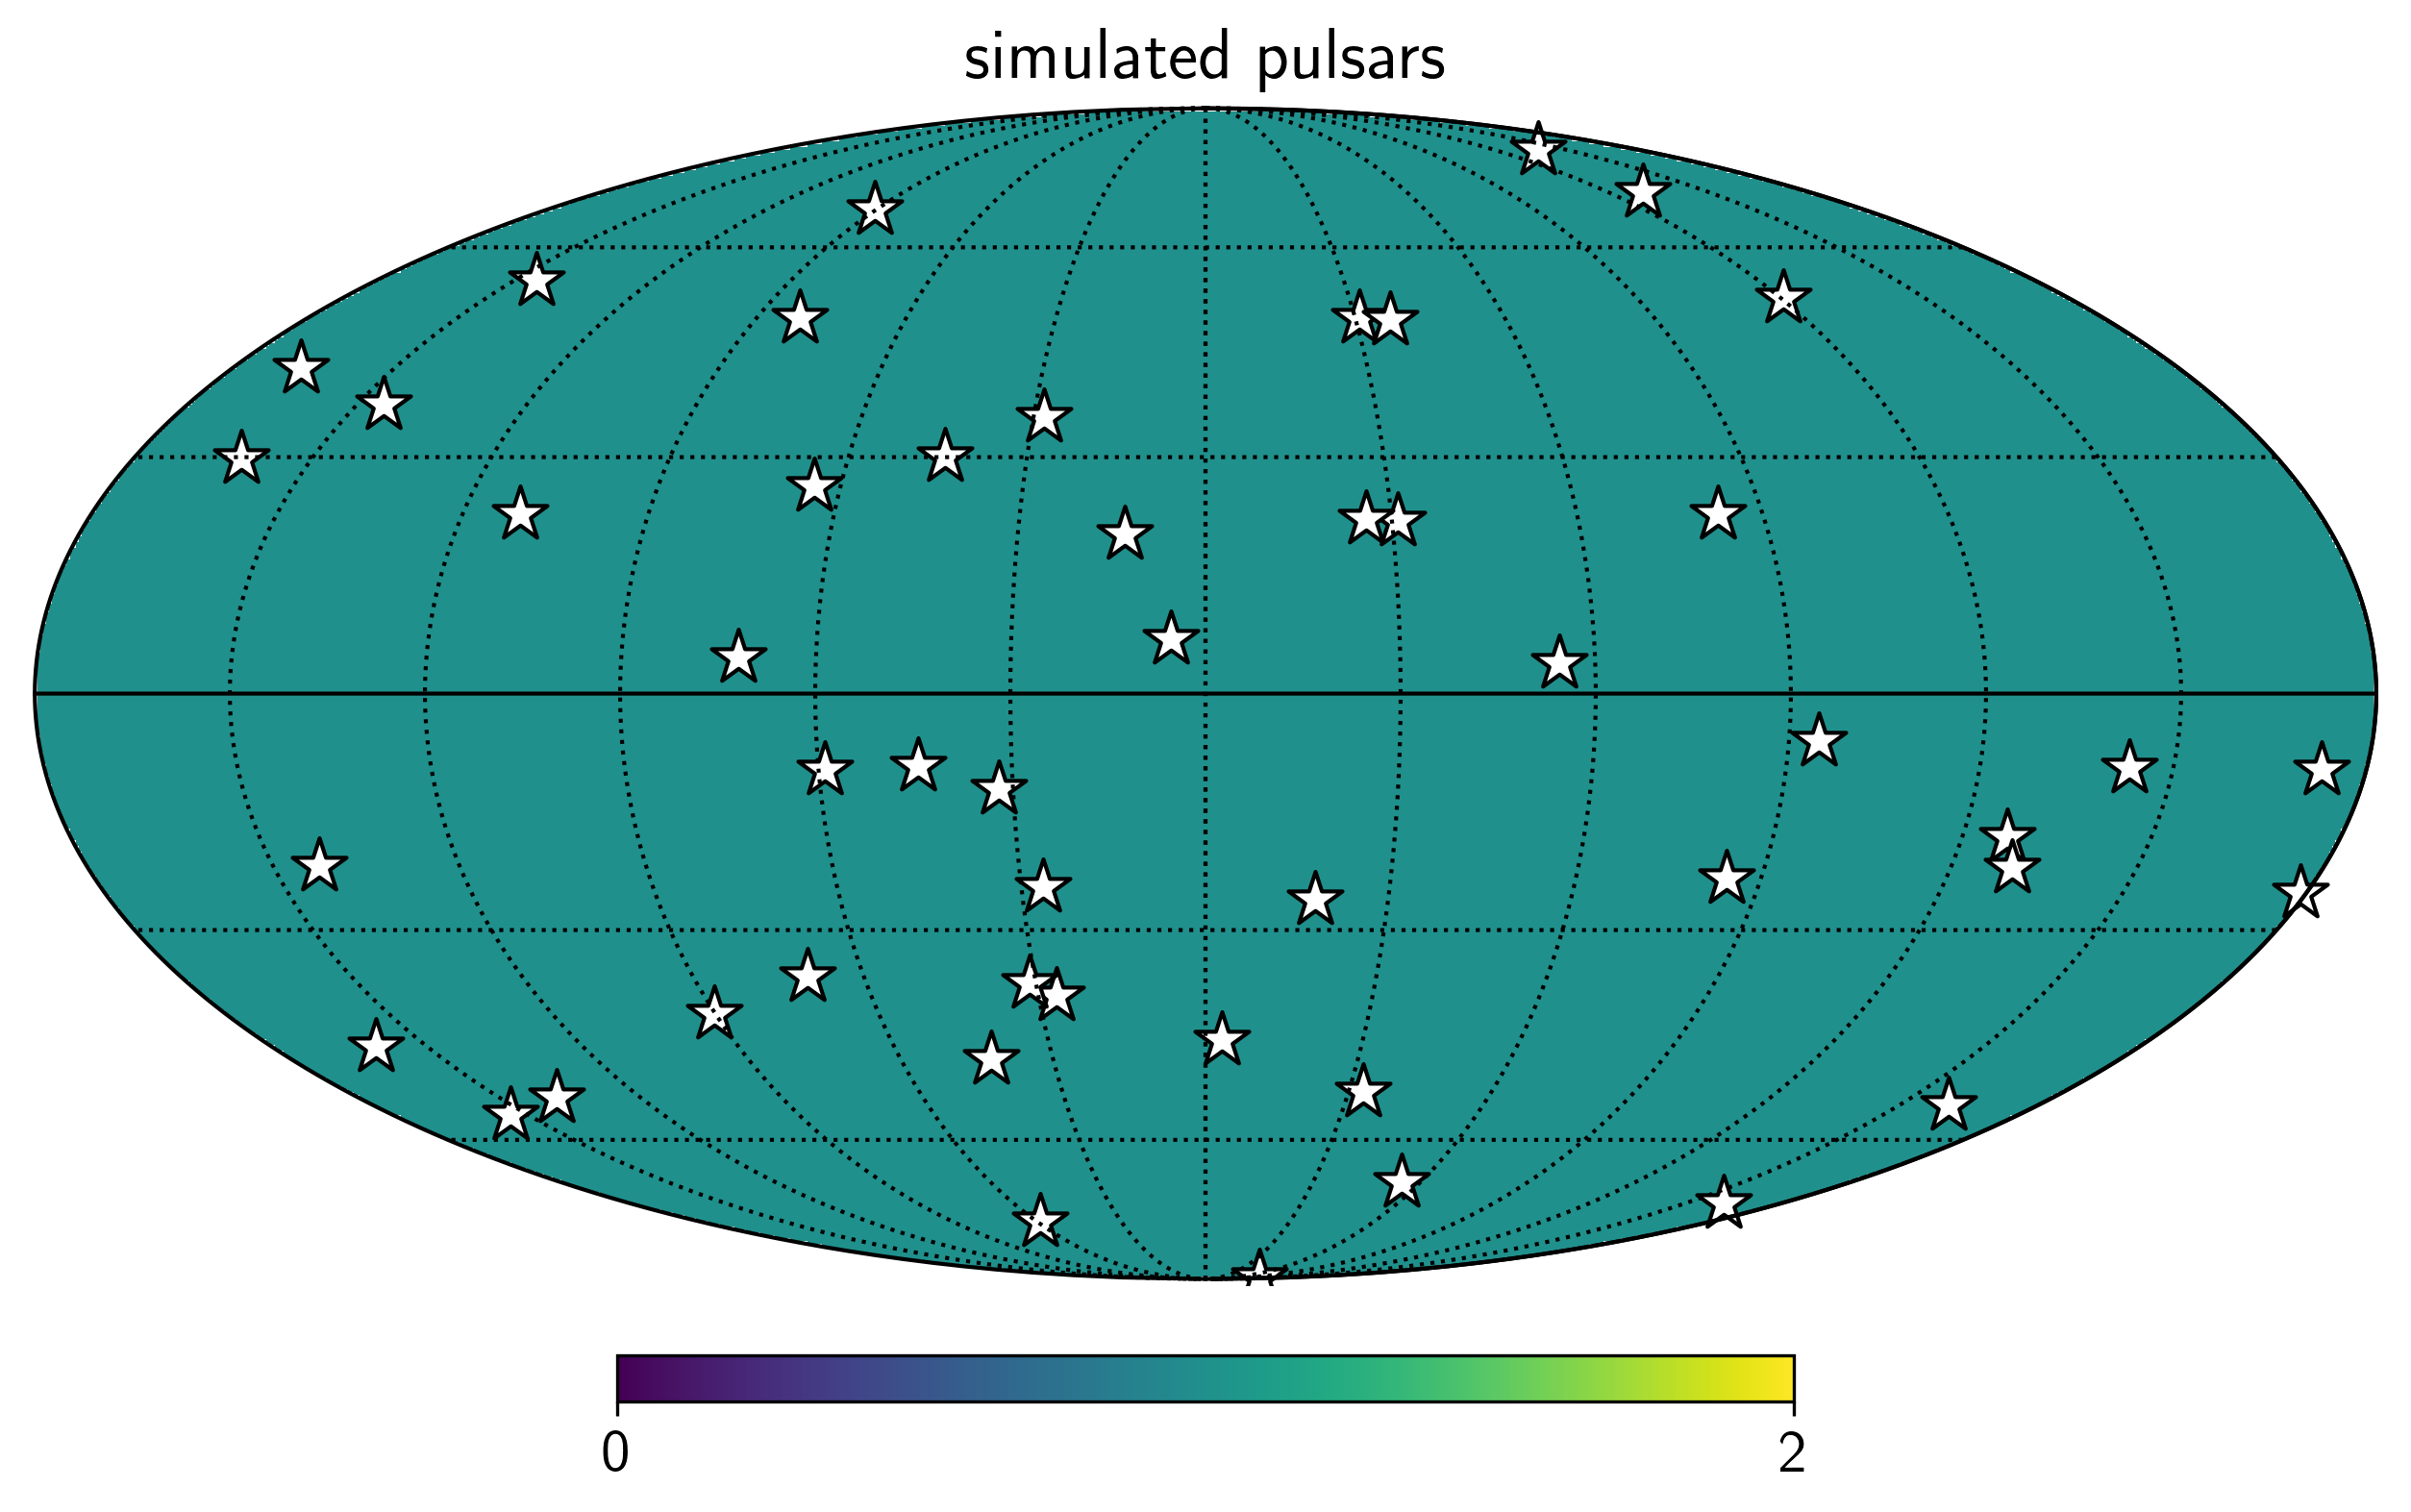

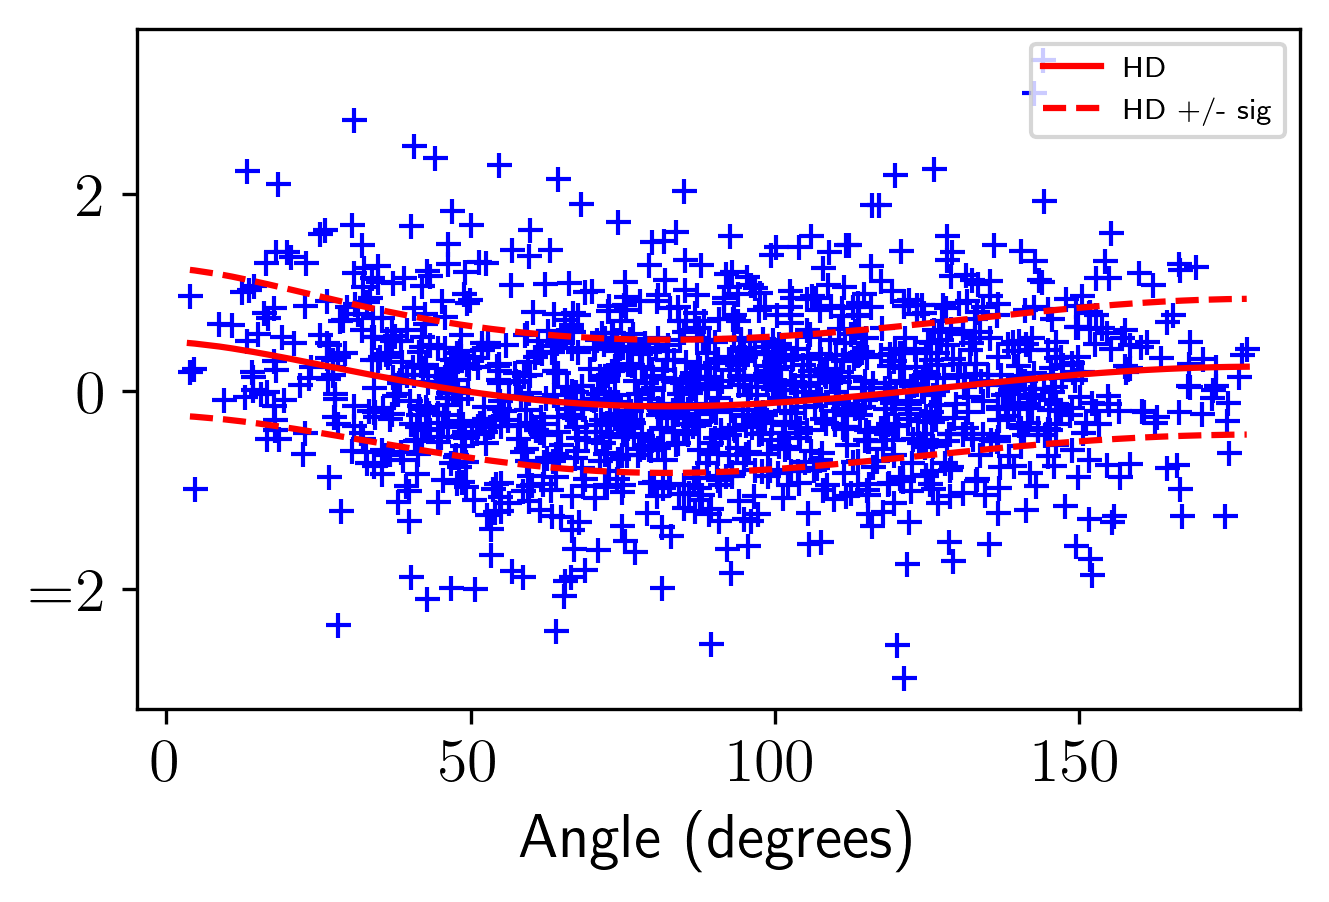

In [9]:
# simulate HD test
norm = 0.5
M = 50
Npairs = int(M*(M-1)/2)
thetaIJ, alphaIJhat, sigmaIJhat, theta_p, phi_p, h2, h4 = simulateHDTest(M, 5678, norm=norm, alpha=-2/3)
print('ratio = h4/(h2**2) =', h4/(h2**2), '(vs 0.5)')

# calculate expected correlation and variance
gamma = np.sort(thetaIJ)
mu, var = HellingsDowns(gamma, norm=norm)

# plot pulsar locations (fixed for all realizations of the GW sources)
plt.figure()
hp.visufunc.mollview(np.ones(12288),rot=(180,0,0),title="simulated pulsars")
hp.visufunc.projscatter(theta_p,phi_p,marker='*',color='white',edgecolors='k',s=200)
hp.graticule()
plt.savefig('pulsar_sky_locations.pdf', bbox_inches='tight', dpi=400)

# plot estimated and actual Hellings-Downs factors
plt.figure()
plt.plot(thetaIJ*180/np.pi, alphaIJhat, 'b+')
plt.plot(gamma*180/np.pi, mu, color='red', label='HD')
plt.plot(gamma*180/np.pi, mu + np.sqrt(var)*np.sqrt(2*h4/(h2**2)), color='red', ls='--', label='HD +/- sig')
plt.plot(gamma*180/np.pi, mu - np.sqrt(var)*np.sqrt(2*h4/(h2**2)), color='red', ls='--')
plt.legend(loc='upper right', fontsize=7)
plt.xlabel('Angle (degrees)')
plt.savefig('HD_recovery_prebinned.pdf', bbox_inches='tight', dpi=400)

In [10]:
def reorderMatrix(M, idx):
    '''
    reorder or construct a submatrix of M
    '''    
    N = len(idx)
    Ms = np.ones((N,N))
    for ii in range(0,N):
        for jj in range(0,N):
            Ms[ii, jj] = M[idx[ii],idx[jj]]
                        
    return Ms

def simpleavg(x):
    '''
    simple average
    '''
    y = np.mean(x)
    sigy = np.std(x)/np.sqrt(len(x))
    
    return y, sigy

def weightedavg(x, sigx):
    '''
    weighted average of independent samples
    '''
    w = 1./(sigx**2)
    denom = np.sum(w)
    y = np.sum(x*w)/denom
    sigy = np.sqrt(1./denom)
    
    return y, sigy


In [11]:
# sort the cross-correlations by angle zeta
idx = np.argsort(thetaIJ)
theta_sorted = thetaIJ[idx]
HDhat_sorted = alphaIJhat[idx]
sighat_sorted = sigmaIJhat[idx]

# bin the cross-correlations so that there are the same number of pairs per bin
Nbins = 15
Npairsperbin = int(Npairs/Nbins)

theta_mean = []
theta_err = []
HDhat_avg = []
sig_avg = []

i = 0
while i+Npairsperbin <= len(theta_sorted):
    
    theta_mean.append(np.mean(theta_sorted[i:Npairsperbin+i]))
    theta_err.append(np.std(theta_sorted[i:Npairsperbin+i]))
    
    h, s = weightedavg(HDhat_sorted[i:Npairsperbin+i], sighat_sorted[i:Npairsperbin+i])
    HDhat_avg.append(h)
    sig_avg.append(s)
    
    i += Npairsperbin
    
theta_mean = np.array(theta_mean)
theta_err = np.array(theta_err)

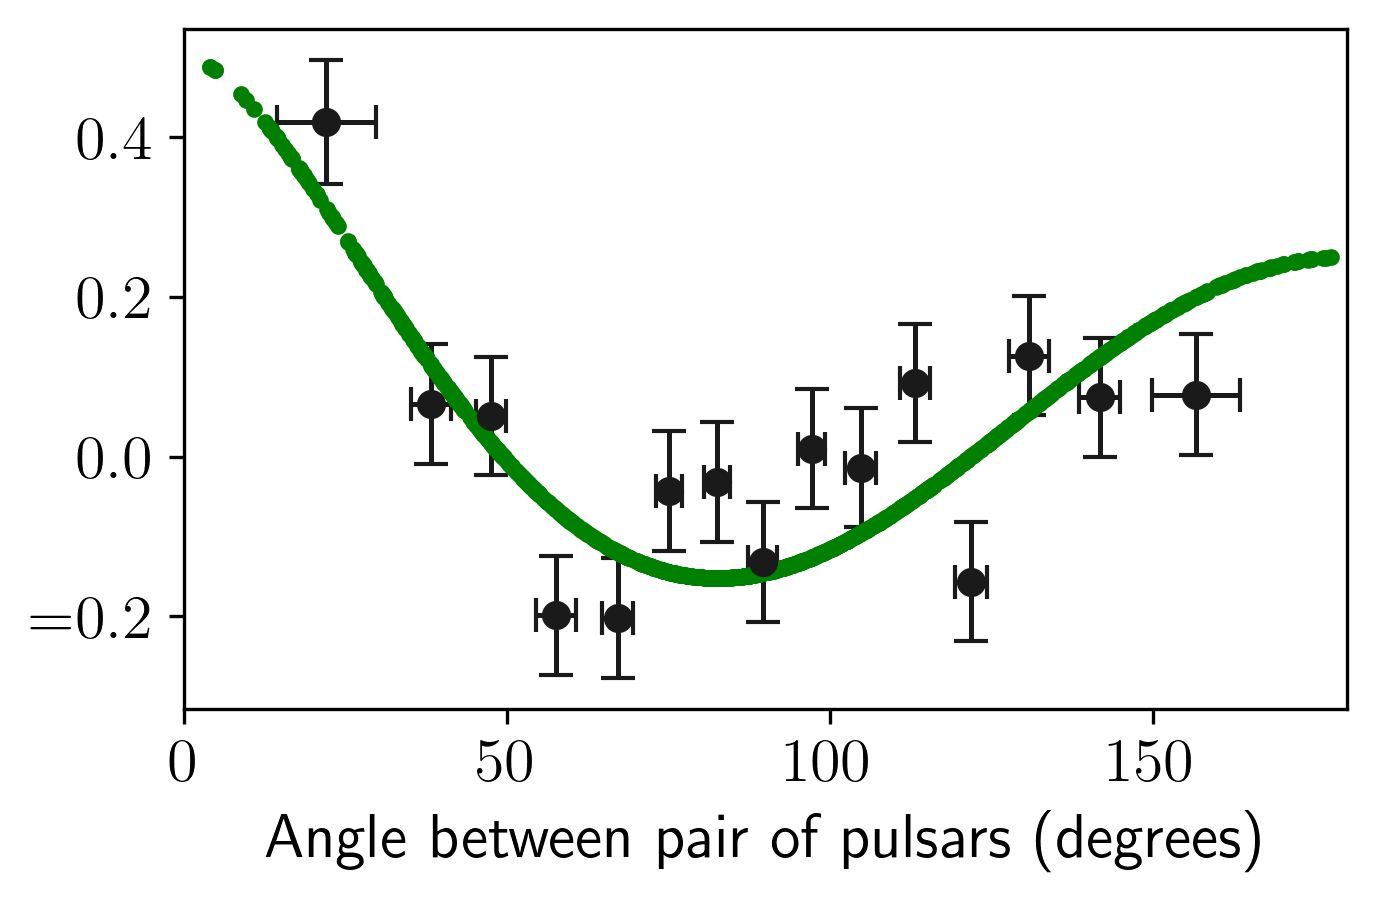

In [12]:
plt.figure()
(_, caps, _) = plt.errorbar(theta_mean*180/np.pi, HDhat_avg, xerr=theta_err*180/np.pi, yerr=sig_avg, marker='o', ls='', 
                            color='0.1', capsize=4, elinewidth=1.2)
plt.plot(gamma*180/np.pi, mu, 'g.')
#plt.plot(gamma*180/np.pi, mu + np.sqrt(var)*np.sqrt(2*h4/(h2**2)), color='orange', ls='dashed')
#plt.plot(gamma*180/np.pi, mu - np.sqrt(var)*np.sqrt(2*h4/(h2**2)), color='orange', ls='dashed')
plt.xlabel('Angle between pair of pulsars (degrees)' )
plt.xlim([0, 180])
plt.savefig('HD_recovery_binned.pdf', bbox_inches='tight', dpi=400)

# equal angular separation bins

In [13]:
def IJ2ndx(I, J, M):
    '''
    convert I<J values to a pulsar pair ndx for M pulsars
    '''
    
    if I>=J:
        print('ERROR: need I < J')
        
    start_ndx = M*I - int(I*(I+1)/2)
    ndx = start_ndx + (J-I)-1;
    
    return ndx

def theta2bin(theta, width):
    '''
    return bin number (starting at 0) corresponding to the value of theta
    '''   
    
    return int(np.floor(theta/width))

In [14]:
# equal angular separation bins
nbins = 15
binwidth = np.pi/15
bins = np.arange(binwidth/2, np.pi+binwidth/2, binwidth)

# convert sigma to variance
varIJhat = sigmaIJhat**2

# initialize some arrays
measured_corr = np.zeros(Npairs)
measured_corr[:] = np.nan
CC_per_bin = np.zeros(nbins)
CC_per_bin[:] = np.nan
numerator_per_bin = np.zeros(nbins)
denominator_per_bin = np.zeros(nbins)
error_per_bin = np.zeros(nbins)
pairs_per_bin = np.zeros(nbins)

k = 0
for jj in range(0,M):
    # add new pairs of pulsars to the appropriate bin    
    if jj>0:
        
        for ii in range(0,jj):
            ndx = IJ2ndx(ii, jj, M)
            theta = thetaIJ[ndx]
            measured_corr[ndx] = alphaIJhat[ndx]
            
            # add this pulsar pair to the appropriate angular bin
            bin_index = theta2bin(theta, binwidth)
            pairs_per_bin[bin_index] = pairs_per_bin[bin_index]+1
            
            numerator_per_bin[bin_index] = numerator_per_bin[bin_index] + alphaIJhat[ndx]/varIJhat[ndx]
            denominator_per_bin[bin_index] = denominator_per_bin[bin_index] + 1/varIJhat[ndx]
            
            CC_per_bin[bin_index] = numerator_per_bin[bin_index]/denominator_per_bin[bin_index]
            error_per_bin[bin_index] = np.sqrt(1/denominator_per_bin[bin_index])
    

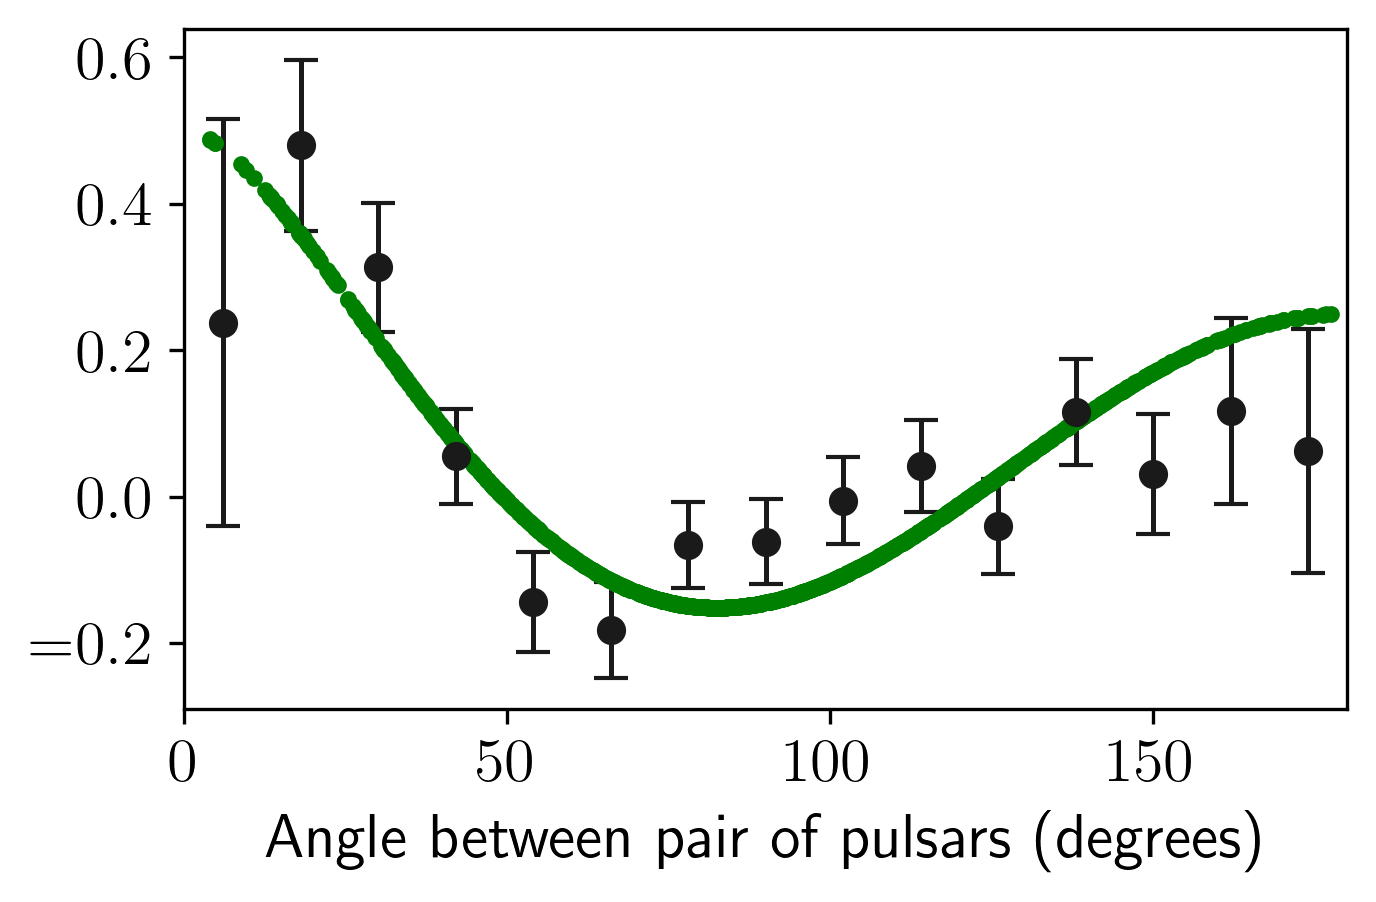

In [15]:
# make plots
plt.figure()
(_, caps, _) = plt.errorbar(bins*180/np.pi, CC_per_bin, yerr=error_per_bin, marker='o', ls='', 
                            color='0.1', capsize=4, elinewidth=1.2)
plt.plot(gamma*180/np.pi, mu, 'g.')
plt.xlabel('Angle between pair of pulsars (degrees)' )
plt.xlim([0, 180])
plt.savefig('HD_recovery_binned_equalbinwidths.pdf', bbox_inches='tight', dpi=400)